In [1]:
#importing libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
#load datasets
patients_df = pd.read_csv('PATIENTS.csv')
admissions_df = pd.read_csv('ADMISSIONS.csv')
icustays_df = pd.read_csv('ICUSTAYS.csv')
diagnoses_df = pd.read_csv('DIAGNOSES_ICD.csv')
labevents_df = pd.read_csv('LABEVENTS.csv')
chartevents_df = pd.read_csv('CHARTEVENTS.csv',low_memory=False)

In [3]:
#now we are converting the admission date and time to pandas format for simplyfying the further process
admissions_df['admittime'] = pd.to_datetime(admissions_df['admittime'])
admissions_df['dischtime'] = pd.to_datetime(admissions_df['dischtime'])
icustays_df['intime'] = pd.to_datetime(icustays_df['intime'])
icustays_df['outtime'] = pd.to_datetime(icustays_df['outtime'])

In [4]:
#now we change the dob to pandas format and find age of the patients 

patients_df['dob'] = pd.to_datetime(patients_df['dob'])
admissions_df['age'] = admissions_df['admittime'].dt.year - patients_df['dob'].dt.year
admissions_df['age'] = admissions_df['age'].apply(lambda x: x if x < 300 else np.nan)  # Handle improbable ages

In [5]:
#now we need to find the total time the patient has taken tostay in icu
icustays_df['icu_los_hours'] = (icustays_df['outtime'] - icustays_df['intime']).dt.total_seconds() / 3600

In [6]:
imputer = SimpleImputer(strategy='mean')
admissions_df['age'] = imputer.fit_transform(admissions_df[['age']])

In [7]:
#NOW we come ot the part of feature engineering
merged_df = pd.merge(patients_df, admissions_df, on='subject_id')
merged_df = pd.merge(merged_df, icustays_df, on=['subject_id', 'hadm_id'])

In [8]:
features = ['age', 'gender', 'ethnicity', 'icu_los_hours'] #we take the feature that we want from the merged df
X = merged_df[features]

In [9]:
# Convert categorical variables to dummy/indicator variables
X = pd.get_dummies(X, columns=['gender', 'ethnicity'], drop_first=True)

In [10]:
#Define the Target Variable

merged_df['in_hospital_mortality'] = np.where(merged_df['dischtime'] < merged_df.get('dod', pd.NaT), 1, 0)
y = merged_df['in_hospital_mortality']

In [11]:
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
#Model Training
rf_model = RandomForestClassifier(random_state=42)

In [14]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [15]:
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

In [16]:
# Get the best model from grid search
best_rf_model = grid_search.best_estimator_

In [17]:
# Step 8: Model Evaluation
y_pred = best_rf_model.predict(X_test)
y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]

In [18]:
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

In [19]:
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.71
ROC-AUC Score: 0.63
Confusion Matrix:
[[ 5  4]
 [ 4 15]]
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.56      0.56         9
           1       0.79      0.79      0.79        19

    accuracy                           0.71        28
   macro avg       0.67      0.67      0.67        28
weighted avg       0.71      0.71      0.71        28



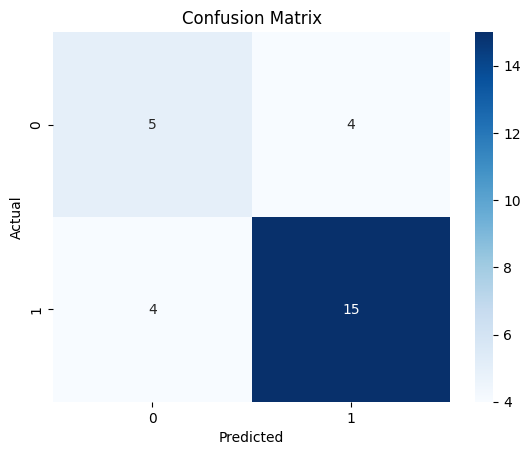

In [20]:
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [21]:
# Step 10: Model Deployment
# Save the model and scaler for deployment
joblib.dump(best_rf_model, 'rf_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [22]:
# Example of loading the model and making a prediction
loaded_model = joblib.load('rf_model.pkl')
loaded_scaler = joblib.load('scaler.pkl')


In [23]:
sample_data = X_test[0].reshape(1, -1)
prediction = loaded_model.predict(sample_data)
print(f"Predicted outcome: {'In-hospital mortality' if prediction == 1 else 'Survival'}")

Predicted outcome: In-hospital mortality


In [24]:
#gridsearch of random forest to improrve accuracy (failure)
param_grid = {
    'n_estimators': [1000, 2000, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [4, 10, 20],
    'min_samples_leaf': [2, 4, 8],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1000}
Best Score: 0.6865800865800866


In [25]:
from sklearn.model_selection import cross_val_score

# Initialize the model with best parameters (after grid search)
best_rf_model = RandomForestClassifier(**grid_search.best_params_, random_state=42)

# Perform k-fold cross-validation (e.g., 5 folds)
cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5)

# Output the cross-validation scores
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

Cross-Validation Scores: [0.63636364 0.59090909 0.68181818 0.76190476 0.76190476]
Mean CV Accuracy: 0.6866


**Now instead of random forest let us try different model algorithms**

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

# Load your preprocessed data (assuming 'X' for features and 'y' for labels)
# Example: X, y = load_your_data() -> Replace with your data loading code

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data (important for many models, especially SVM and KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dictionary to store results of each model
model_performance = {}

# Helper function to evaluate a model
def evaluate_model(model, model_name):
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Predict on test data
    y_pred = model.predict(X_test_scaled)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.4f}")
    
    # Classification report
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    
    # Store performance
    model_performance[model_name] = accuracy

# 1. Logistic Regression
log_reg = LogisticRegression(random_state=42)
evaluate_model(log_reg, "Logistic Regression")

# 2. Support Vector Machine (SVM)
svm = SVC(kernel='linear', random_state=42)
evaluate_model(svm, "Support Vector Machine")

# 3. K-Nearest Neighbors (KNN)
knn = KNeighborsClassifier(n_neighbors=5)
evaluate_model(knn, "K-Nearest Neighbors")

# 4. Gradient Boosting
gbc = GradientBoostingClassifier(random_state=42)
evaluate_model(gbc, "Gradient Boosting")

# 5. XGBoost
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False)
evaluate_model(xgb_model, "XGBoost")

# Compare model performance
print("\nModel Performance Summary:")
for model_name, accuracy in model_performance.items():
    print(f"{model_name}: {accuracy:.4f}")

Logistic Regression Accuracy: 0.7143
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.50      0.25      0.33         8
           1       0.75      0.90      0.82        20

    accuracy                           0.71        28
   macro avg       0.62      0.57      0.58        28
weighted avg       0.68      0.71      0.68        28

Support Vector Machine Accuracy: 0.7500
Classification Report for Support Vector Machine:
              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.74      1.00      0.85        20

    accuracy                           0.75        28
   macro avg       0.87      0.56      0.54        28
weighted avg       0.81      0.75      0.67        28

K-Nearest Neighbors Accuracy: 0.5714
Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.00      0.00

C:\Users\17385\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:35:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [27]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],   # Regularization parameter
    'gamma': [1, 0.1, 0.01, 0.001],  # Kernel coefficient for 'rbf', 'poly'
    'kernel': ['linear', 'rbf', 'poly']  # Kernel type
}

# Initialize the SVM model
svm_model = SVC()

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

# Fit the grid search
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_}")

# Use the best model to predict on the test set
best_svm_model = grid_search.best_estimator_
y_pred = best_svm_model.predict(X_test_scaled)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Optimized SVM Accuracy: {accuracy:.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Best Cross-Validation Score: 0.6575757575757575
Optimized SVM Accuracy: 0.7143


In [28]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

# Initialize the SVM model
svm = SVC(kernel='linear')

# Use Recursive Feature Elimination
rfe = RFE(estimator=svm, n_features_to_select=10)  # Select top 10 features
rfe.fit(X_train_scaled, y_train)

# Use the selected features to train the model
X_train_rfe = rfe.transform(X_train_scaled)
X_test_rfe = rfe.transform(X_test_scaled)

# Train the SVM model on reduced feature set
svm.fit(X_train_rfe, y_train)
y_pred = svm.predict(X_test_rfe)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy with RFE: {accuracy:.4f}")

SVM Accuracy with RFE: 0.7500


In [29]:
#trying to get th ebest estimator for svm (another failure :( 
from sklearn.model_selection import cross_val_score

# Perform cross-validation with the best model
cv_scores = cross_val_score(best_svm_model, X_train_scaled, y_train, cv=10)

# Output cross-validation scores
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}")

Cross-Validation Scores: [0.63636364 0.63636364 0.63636364 0.63636364 0.63636364 0.63636364
 0.63636364 0.72727273 0.7        0.7       ]
Mean Cross-Validation Accuracy: 0.6582


In [30]:
#kernel rbf run
best_svm_model_rbf = SVC(kernel='rbf', C=grid_search.best_params_['C'], 
                         gamma=grid_search.best_params_['gamma'])

best_svm_model_rbf.fit(X_train_scaled, y_train)
y_pred_rbf = best_svm_model_rbf.predict(X_test_scaled)

accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
print(f"SVM Accuracy with RBF Kernel: {accuracy_rbf:.4f}")

SVM Accuracy with RBF Kernel: 0.7143


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'C': stats.uniform(0.01, 1000),  # Continuous distribution for C
    'gamma': stats.uniform(0.001, 100),  # Continuous distribution for gamma
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Discrete choices
    'degree': stats.randint(2, 5),  # Integer distribution for degree
    'coef0': stats.uniform(0.0, 1.0),  # Continuous distribution for coef0
    'class_weight': ['balanced', None],  # Discrete choices
    'shrinking': [True, False],  # Discrete choices
    'tol': stats.uniform(1e-5, 1e-3)  # Continuous distribution for tolerance
}

# Initialize the SVM model
svm_model = SVC()

# Perform Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(estimator=svm_model, param_distributions=param_dist, 
                                   n_iter=50, cv=5, n_jobs=-1, verbose=2, random_state=42)

# Fit the random search to the data
random_search.fit(X_train_scaled, y_train)

# Get the best parameters and score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Cross-Validation Score: {random_search.best_score_}")

# Use the best model to predict on the test set
best_svm_model = random_search.best_estimator_
y_pred = best_svm_model.predict(X_test_scaled)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Optimized SVM Accuracy with RandomizedSearchCV: {accuracy:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
